Here we will not only predict the coordinates of the projectile. We will also calculate the value of *g* with the predicted output and use it as a loss function. 

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random

In [2]:
SCALE_FACTOR = 100
BATCH_SIZE = 64

In [3]:
def get_pos(v:float, theta:float, t:float, return_tensor=True):
    """This Return the (x,y) cord for the given projectile parameter.

    Args:
        v (float): velocity in m/s^2
        theta (float): angle of  projectile in radian
        t (float): time in second

    Returns:
        x, y
    """
    x = v*np.cos(theta)*t
    y = -0.5*9.8*t**2 + v*np.sin(theta)*t

    if return_tensor:
        return torch.tensor([x,y], dtype=torch.float)
    
    return x, y

In [4]:
def get_timeOfFlight(v0:float, theta:float):
    """_summary_

    Args:
        v0 (float): velocity m/s^2
        theta (float): angle in rad

    Returns:
        T (float): time of flight
    """
    g = 9.8
    T = 2*(v0*np.sin(theta))/g
    
    return T

In [5]:
def get_sample_data():
    """Generate Sample Data

    Returns:
        [v0, theta, t] : input where v0 and t is scalled with a scale factor.
        [x, y] : output are scalled with a scale factor.
        [T] : time of flight

    """
    g = 9.8
    v0 = np.random.randint(1,100)
    theta = np.random.randint(1,91)
    theta = np.deg2rad(theta)
    
    T = 2*(v0*np.sin(theta)/g)
    # print(T, v0, theta)
    
    if T>0.1:
        t = np.random.uniform(0, T)
    else:
        t = T

    x, y = get_pos(v0, theta, t, return_tensor=False)
    # return torch.tensor([v0, theta, t], dtype=torch.float), torch.tensor([x,y], dtype=torch.float)
    return [v0/SCALE_FACTOR, theta, t/SCALE_FACTOR], [x/SCALE_FACTOR,y/SCALE_FACTOR], [T]

In [6]:
# get_sample_data()

In [7]:
def plain_equation_g(v0, alpha, t, y):
    """Calculate g with equation

    Args:
        v (_type_): _description_
        alpha (_type_): _description_
        t (_type_): _description_
        y (_type_): _description_
    """
    g_calc = 2 * ( v0 * np.sin(alpha) * t - y) / (t**2)
    return g_calc

In [8]:
def get_g_value(inp,pred):
# extracting values from tensor column axis
    if SCALE_FACTOR==0 or SCALE_FACTOR==1: #NO SCALING
        v0 = inp[:,0]
        alpha = inp[:,1]
        t = inp[:,2]
        y_pred = pred[:, 1]
    else:
        v0 = inp[:,0]*SCALE_FACTOR
        alpha = inp[:,1]
        t = inp[:,2]*SCALE_FACTOR
        y_pred = pred[:, 1]*SCALE_FACTOR
    
    # Calculate g using the formula: g = -2(y - v0 * sin(alpha) * t) / (t^2)
    g_calc = 2 * ( v0 * torch.sin(alpha) * t - y_pred) / (t**2)
    # print("inside fnc", g_calc)
    # return torch.mean((0.096-g_calc/100))**2

    return g_calc/SCALE_FACTOR


In [9]:
class ProjectileData(Dataset):
    def __init__(self, data_size=1000):
        # datata generation 
        X_train = []
        Y_train = []
        T = []
        for _ in range(data_size):
            x_t, y_t, t = get_sample_data()
            X_train.append(x_t)
            Y_train.append(y_t)
            T.append(t)

        self.X_train = torch.tensor(X_train, dtype=torch.float)
        self.Y_train = torch.tensor(Y_train, dtype=torch.float)
        self.T = torch.tensor(T, dtype=torch.float)
    
    def __len__(self):
        return self.X_train.shape[0]
    
    def __getitem__(self, index):
        # return self.X_train[index]/SCALE_FACTOR, self.Y_train[index]/SCALE_FACTOR, self.T[index]
        return self.X_train[index], self.Y_train[index], self.T[index]

In [10]:
dataset = ProjectileData(data_size=6400)

In [11]:
train_dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Model Definition

In [13]:
class PINNv3(nn.Module):
    def __init__(self, inp_size, out_size) -> None:
        super().__init__()
        self.layer1 = nn.Linear(inp_size, 128)
        self.norm1 = nn.LayerNorm(128)
        self.layer2 = nn.Linear(128, 64)
        self.norm2 = nn.LayerNorm(64)
        self.layer3 = nn.Linear(64, out_size)

    def forward(self, x):
        x = F.tanh(self.norm1(self.layer1(x)))
        x = F.tanh(self.norm2(self.layer2(x)))

        return self.layer3(x)

In this training procedure we will not only calculate the error between prediction, we will also use the predicted output to predict the *g* value and then we will calculate the error between predicted *g'* and actual *g*. Let's call it g-loss. 

In [15]:
model = PINNv3(3,2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_mse = nn.MSELoss()
# loss_g_mse = nn.MSELoss()
loss_g_mse = nn.SmoothL1Loss()

# loss_fn = nn.MSELoss()


model.to(device)
loss_mse.to(device)
loss_g_mse.to(device)

SmoothL1Loss()

In [16]:
# load pretrained model
# model.load_state_dict(torch.load("checkpoint/PINNv2_model_ep10000_1721072586.pt"))
model.load_state_dict(torch.load("checkpoint/PINNv3_model_ep10000_1722108340.pt"))


<All keys matched successfully>

In [17]:
g = torch.tensor([0.0980]*BATCH_SIZE)
g

tensor([0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980, 0.0980,
        0.0980])

In [18]:
# x,y,_ = next(iter(train_dataloader))


In [19]:
# loss_g_l1 = nn.SmoothL1Loss()

In [20]:
# model.eval()
# with torch.no_grad():
#     y_ = model(x.to(device))

#     g_ = get_g_value(x.to(device),y_)
#     le = loss_mse(y.to(device), y_)
#     lg = loss_g_mse(g.to(device),g_)
#     l1g = loss_g_l1(g.cuda(), g_)
#     print(le, lg, l1g)
    

In [21]:
# g_

In [22]:
# torch.abs(torch.subtract(g.cuda(),g_)).square().mean()

### Training with Physics Information

In [23]:
# g.to(device)

In [24]:
# training loop 
EPOCH = 1000
history  = []

for epoch in range(1, EPOCH+1):

    # set model into training mode
    model.train()
    running_loss = 0.0
    count = 0
    for i, (inp, out, _) in  enumerate(train_dataloader):
        optimizer.zero_grad()

        # dataset data
        x = inp.cuda()
        y = out.cuda()

        # forward pass and predict output
        y_ = model(x)

        # calculate physical value
        g_ = get_g_value(inp=x, pred=y_).float()

        # calculate mse loss and phy_loss (with clip)
        mse_loss  = loss_mse(y, y_).float()
        phy_loss = loss_g_mse(g.to(device),g_).clip(min=-0.12,max=10)
        # phy_loss = loss_g_mse(g.to(device),g_)
    
        loss = mse_loss+phy_loss
        
        
        # backprop
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print(loss.item(), mse_loss.item(), phy_loss.item())
        # print(y,y_)
        print(f"{epoch}|{EPOCH} LOSS:{running_loss/len(train_dataloader)} mse {mse_loss.item()} phy_loss {phy_loss.item()}", end="\r")

        
    # break
    if epoch%100==0:
        print("\n")
        # mini validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            v, alpha, t = 99, 51 ,13
            alpha = np.deg2rad(alpha)
            print("Validation at", epoch)
            validation_sample = torch.tensor([v/SCALE_FACTOR, alpha, t/SCALE_FACTOR], dtype=torch.float)
            pred_y = model(validation_sample.to(device))*SCALE_FACTOR
            val_y = get_pos(v=v, theta=alpha, t=t)
            print("Input", v, np.rad2deg(alpha), t, " Output", pred_y, " Truth", val_y)
        
        print(f"\n")

    history.append(running_loss/len(train_dataloader))


100|1000 LOSS:10.37902307510376 mse 1.1082396507263184 phy_loss 10.004196853637695552626

Validation at 100
Input 99 51.0 13  Output tensor([428.7115,  53.6730], device='cuda:0')  Truth tensor([809.9354, 172.0869])




KeyboardInterrupt: 

## Obesrvation
The overall loss functions does not improve and the physics loss (g-loss) does not improve.

## Question 
Is the neural network actually physics informed? 

In [24]:
import matplotlib.pyplot as plt

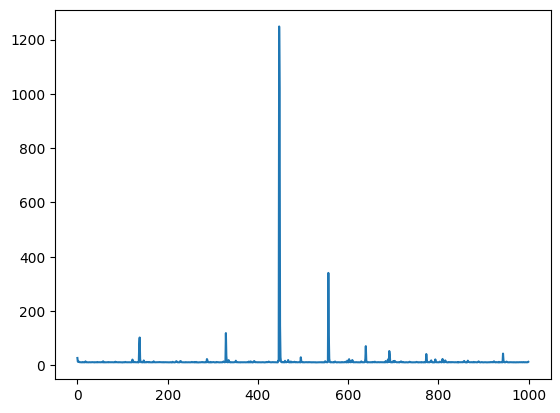

In [25]:
plt.plot(history)

In [21]:
# import time

In [22]:
# torch.save(model.state_dict(), f"checkpoint/{model._get_name()}_gloss_model_ep{EPOCH}_{int(time.time())}.pt")